# 15. Reinforcement Learning
## CPE 490 590
## Rahul Bhadani


## 1. Markove Chain

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

class MarkovChain:
    def __init__(self, transition_matrix, states):
        """
        Initialize the Markov chain with transition matrix and state names.
        
        Args:
            transition_matrix: 2D numpy array where [i,j] is the probability of transitioning from state i to state j
            states: List of state names
        """
        self.transition_matrix = np.array(transition_matrix)
        self.states = states
        self.n_states = len(states)
        
        # Validate that each row sums to 1 (valid probability distribution)
        row_sums = np.sum(self.transition_matrix, axis=1)
        if not np.allclose(row_sums, np.ones(self.n_states)):
            print("Warning: Transition matrix rows don't sum to 1")
            print(f"Row sums: {row_sums}")
    
    def next_state(self, current_state_idx):
        """Generate the next state based on transition probabilities."""
        return np.random.choice(self.n_states, p=self.transition_matrix[current_state_idx])
    
    def generate_sequence(self, start_state_idx, length):
        """Generate a sequence of states starting from start_state."""
        current_state = start_state_idx
        sequence = [current_state]
        
        for _ in range(length-1):
            next_state_idx = self.next_state(current_state)
            sequence.append(next_state_idx)
            current_state = next_state_idx
            
        return sequence
    
# Define the transition matrix based on the diagram
# State 0: Dark blue
# State 1: Green
transition_matrix = np.array([
    [0.3, 0.7],  # From State 0: 0.3 probability to stay, 0.7 probability to go to State 1
    [0.9, 0.1]   # From State 1: 0.9 probability to go to State 0, 0.1 probability to stay
])

# Initialize the Markov chain
mc = MarkovChain(transition_matrix, states=["s0", "s1"])

# Example: Generate a sequence of 10 states starting from State 0
sequence = mc.generate_sequence(0, 10)
print("Generated sequence:", [mc.states[i] for i in sequence])


# Simulate the Markov chain for many steps to find steady state
def simulate_steady_state(mc, start_state=0, num_steps=100000):
    current = start_state
    state_counts = {i: 0 for i in range(mc.n_states)}
    
    for _ in range(num_steps):
        state_counts[current] += 1
        current = mc.next_state(current)
    
    # Convert counts to probabilities
    total = sum(state_counts.values())
    steady_state = {mc.states[i]: count/total for i, count in state_counts.items()}
    return steady_state

# Calculate steady state distribution
steady_state = simulate_steady_state(mc)
print("\nSteady state distribution (simulated):")
for state, prob in steady_state.items():
    print(f"State {state}: {prob:.4f}")

# Theoretical steady state calculation using linear algebra
def calculate_steady_state(transition_matrix):
    """Calculate the steady state distribution analytically."""
    # For a Markov chain with transition matrix P, the steady state π satisfies π = πP
    # This means π(P - I) = 0, plus we need the constraint that sum(π) = 1
    
    n = len(transition_matrix)
    A = np.vstack([np.transpose(transition_matrix) - np.eye(n), np.ones(n)])
    b = np.zeros(n+1)
    b[-1] = 1
    
    # Solve the system of equations
    try:
        steady_state = np.linalg.lstsq(A, b, rcond=None)[0]
        return steady_state
    except np.linalg.LinAlgError:
        return None

# Calculate theoretical steady state
theoretical_steady_state = calculate_steady_state(transition_matrix)
if theoretical_steady_state is not None:
    print("\nTheoretical steady state distribution:")
    for i, prob in enumerate(theoretical_steady_state):
        print(f"State {mc.states[i]}: {prob:.4f}")

Generated sequence: ['s0', 's1', 's0', 's1', 's0', 's1', 's0', 's1', 's0', 's0']

Steady state distribution (simulated):
State s0: 0.5619
State s1: 0.4381

Theoretical steady state distribution:
State s0: 0.5625
State s1: 0.4375


# 2. Markov Chain with Actions

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

class MarkovDecisionProcess:
    def __init__(self, transition_matrices, states, actions):
        """
        Initialize the Markov Decision Process with just states and actions.
        
        Args:
            transition_matrices: List of 2D numpy arrays, one for each action
                                where transition_matrices[a][i,j] is the probability 
                                of transitioning from state i to state j when taking action a
            states: List of state names
            actions: List of action names
        """
        self.transition_matrices = [np.array(tm) for tm in transition_matrices]
        self.states = states
        self.actions = actions
        self.n_states = len(states)
        self.n_actions = len(actions)
        
        # Validate transition matrices
        for a, tm in enumerate(self.transition_matrices):
            row_sums = np.sum(tm, axis=1)
            if not np.allclose(row_sums, np.ones(self.n_states)):
                print(f"Warning: Transition matrix for action {actions[a]} rows don't sum to 1")
                print(f"Row sums: {row_sums}")
    
    def next_state(self, current_state, action):
        """Generate the next state based on current state and action."""
        return np.random.choice(self.n_states, p=self.transition_matrices[action][current_state])
    
    def generate_sequence(self, start_state, action_sequence):
        """
        Generate a sequence of states based on a starting state and sequence of actions.
        
        Args:
            start_state: Index of the starting state
            action_sequence: List of action indices to take
            
        Returns:
            List of states visited
        """
        current_state = start_state
        states_visited = [current_state]
        
        for action in action_sequence:
            current_state = self.next_state(current_state, action)
            states_visited.append(current_state)
            
        return states_visited
    
    def simulate_random_actions(self, start_state, length):
        """
        Simulate taking random actions for a specified length.
        
        Args:
            start_state: Index of the starting state
            length: Number of actions to take
            
        Returns:
            Tuple of (state_sequence, action_sequence)
        """
        current_state = start_state
        state_sequence = [current_state]
        action_sequence = []
        
        for _ in range(length):
            # Choose a random action
            action = random.randint(0, self.n_actions - 1)
            action_sequence.append(action)
            
            # Transition to next state based on the action
            current_state = self.next_state(current_state, action)
            state_sequence.append(current_state)
            
        return state_sequence, action_sequence
    
    def action_transition_probability(self, from_state, to_state):
        """
        Calculate the probability of transitioning from one state to another for each action.
        
        Args:
            from_state: Starting state index
            to_state: Ending state index
            
        Returns:
            Dictionary mapping action names to transition probabilities
        """
        probs = {}
        for a in range(self.n_actions):
            probs[self.actions[a]] = self.transition_matrices[a][from_state, to_state]
        return probs


# Define actions for our MDP
actions = ["stay_cautious", "explore_aggressively"]

# Define transition matrices for each action
# For stay_cautious:
transition_matrix0 = np.array([
    [0.3, 0.7],  # From State 0
    [0.9, 0.1]   # From State 1
])

# For explore_aggressively: different transition probabilities
transition_matrix1 = np.array([
    [0.8, 0.2],  # From State 0
    [0.4, 0.6]   # From State 1
])

transition_matrices = [transition_matrix0, transition_matrix1]

# Initialize the MDP
mdp = MarkovDecisionProcess(transition_matrices, states=["s0", "s1"], actions=actions)

# Example: Generate a sequence with a specific action sequence
action_sequence = [0, 1, 0, 1, 1]  # Alternate between actions
state_sequence = mdp.generate_sequence(0, action_sequence)
print("\nState sequence with predefined actions:")
for i, state in enumerate(state_sequence):
    if i < len(action_sequence):
        print(f"At state {mdp.states[state]}, took action {mdp.actions[action_sequence[i]]}")
    else:
        print(f"Ended at state {mdp.states[state]}")

# Simulate random actions
random_states, random_actions = mdp.simulate_random_actions(0, 10)
print("\nSimulation with random actions:")
for i in range(len(random_actions)):
    print(f"At state {mdp.states[random_states[i]]}, took action {mdp.actions[random_actions[i]]} → state {mdp.states[random_states[i+1]]}")

# Show transition probabilities for each action
print("\nTransition probabilities for each action:")
for s1 in range(mdp.n_states):
    for s2 in range(mdp.n_states):
        probs = mdp.action_transition_probability(s1, s2)
        print(f"From {mdp.states[s1]} to {mdp.states[s2]}:")
        for action, prob in probs.items():
            print(f"  Action '{action}': {prob:.2f}")


State sequence with predefined actions:
At state s0, took action stay_cautious
At state s1, took action explore_aggressively
At state s1, took action stay_cautious
At state s0, took action explore_aggressively
At state s1, took action explore_aggressively
Ended at state s0

Simulation with random actions:
At state s0, took action explore_aggressively → state s0
At state s0, took action stay_cautious → state s1
At state s1, took action explore_aggressively → state s1
At state s1, took action explore_aggressively → state s0
At state s0, took action stay_cautious → state s1
At state s1, took action explore_aggressively → state s1
At state s1, took action explore_aggressively → state s1
At state s1, took action explore_aggressively → state s1
At state s1, took action explore_aggressively → state s1
At state s1, took action explore_aggressively → state s0

Transition probabilities for each action:
From s0 to s0:
  Action 'stay_cautious': 0.30
  Action 'explore_aggressively': 0.80
From s0 t

# 3. Markov Chain with Actions and (State-Action) Rewards

In [2]:
import numpy as np
from copy import deepcopy

class MarkovDecisionProcess:
    def __init__(self, transition_matrices, rewards, states, actions, gamma=0.9):
        """
        Initialize the Markov Decision Process.
        
        Args:
            transition_matrices: List of 2D numpy arrays, one for each action
                                where transition_matrices[a][i,j] is the probability 
                                of transitioning from state i to state j when taking action a
            rewards: 2D numpy array where rewards[s, a] is the reward for taking action a in state s
            states: List of state names
            actions: List of action names
            gamma: Discount factor for future rewards (between 0 and 1)
        """
        self.transition_matrices = [np.array(tm) for tm in transition_matrices]
        self.rewards = np.array(rewards)
        self.states = states
        self.actions = actions
        self.gamma = gamma
        self.n_states = len(states)
        self.n_actions = len(actions)
        
        # Validate transition matrices
        for a, tm in enumerate(self.transition_matrices):
            row_sums = np.sum(tm, axis=1)
            if not np.allclose(row_sums, np.ones(self.n_states)):
                print(f"Warning: Transition matrix for action {actions[a]} rows don't sum to 1")
                print(f"Row sums: {row_sums}")
    
    def next_state(self, current_state, action):
        """Generate the next state based on current state and action."""
        return np.random.choice(self.n_states, p=self.transition_matrices[action][current_state])
    
    def simulate_random_actions(self, start_state, n_steps):
        """
        Simulate taking random actions for n_steps steps, starting from start_state.
        
        Args:
            start_state: Index of the starting state
            n_steps: Number of steps to simulate
            
        Returns:
            history: List of (state, action, reward, next_state) tuples
            total_reward: Sum of rewards
            discounted_reward: Sum of discounted rewards
        """
        current_state = start_state
        history = []
        total_reward = 0
        discounted_reward = 0
        
        for step in range(n_steps):
            # Choose a random action
            action = np.random.randint(0, self.n_actions)
            
            # Get reward for this state-action pair
            reward = self.rewards[current_state, action]
            
            # Calculate next state
            next_state = self.next_state(current_state, action)
            
            # Record state, action, reward, next_state
            history.append((
                self.states[current_state], 
                self.actions[action], 
                reward, 
                self.states[next_state]
            ))
            
            # Update rewards
            total_reward += reward
            discounted_reward += reward * (self.gamma ** step)
            
            # Move to next state
            current_state = next_state
            
        return history, total_reward, discounted_reward


# Define actions for our MDP
actions = ["action0", "action1"]

# Define transition matrices for each action
# For action0:
transition_matrix0 = np.array([
    [0.3, 0.7],  # From State 0
    [0.9, 0.1]   # From State 1
])

# For action1: different transition probabilities
transition_matrix1 = np.array([
    [0.8, 0.2],  # From State 0
    [0.4, 0.6]   # From State 1
])

transition_matrices = [transition_matrix0, transition_matrix1]

# Define rewards - rewards[s, a] is reward for taking action a in state s
rewards = np.array([
    [1, 0],  # Rewards for state 0: action0 gives 1, action1 gives 0
    [0, 2]   # Rewards for state 1: action0 gives 0, action1 gives 2
])

# Initialize the MDP
mdp = MarkovDecisionProcess(transition_matrices, rewards, states=["s0", "s1"], actions=actions)

# Run multiple simulations
n_simulations = 5
n_steps = 10

print(f"Running {n_simulations} simulations with {n_steps} steps each...\n")

for sim in range(n_simulations):
    print(f"Simulation {sim + 1}:")
    
    # Start from random state
    start_state = np.random.randint(0, mdp.n_states)
    print(f"Starting state: {mdp.states[start_state]}")
    
    # Run simulation
    history, total_reward, discounted_reward = mdp.simulate_random_actions(start_state, n_steps)
    
    # Print results
    print("Step | State | Action | Reward | Next State")
    print("-" * 45)
    for i, (state, action, reward, next_state) in enumerate(history):
        print(f"{i+1:4d} | {state:5s} | {action:7s} | {reward:6.1f} | {next_state:5s}")
    
    print(f"\nTotal reward: {total_reward}")
    print(f"Discounted reward (gamma={mdp.gamma}): {discounted_reward:.4f}")
    print("-" * 50)

Running 5 simulations with 10 steps each...

Simulation 1:
Starting state: s0
Step | State | Action | Reward | Next State
---------------------------------------------
   1 | s0    | action1 |    0.0 | s1   
   2 | s1    | action0 |    0.0 | s0   
   3 | s0    | action1 |    0.0 | s1   
   4 | s1    | action0 |    0.0 | s0   
   5 | s0    | action0 |    1.0 | s0   
   6 | s0    | action1 |    0.0 | s0   
   7 | s0    | action0 |    1.0 | s0   
   8 | s0    | action0 |    1.0 | s0   
   9 | s0    | action0 |    1.0 | s1   
  10 | s1    | action0 |    0.0 | s0   

Total reward: 4
Discounted reward (gamma=0.9): 2.0963
--------------------------------------------------
Simulation 2:
Starting state: s0
Step | State | Action | Reward | Next State
---------------------------------------------
   1 | s0    | action1 |    0.0 | s0   
   2 | s0    | action1 |    0.0 | s1   
   3 | s1    | action0 |    0.0 | s1   
   4 | s1    | action0 |    0.0 | s0   
   5 | s0    | action0 |    1.0 | s1   
   

# Grid World RL
## Rahul Bhadani

### Based on work by Eligijus Bujokas

The grid world problem is a classic problem in RL where we want to create an optimal strategy for an agent to traverse a grid.

No matter where our agent is, it can only move either left, right up or down. Now let us define and visualize our grid world:



In [ ]:
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches


In [ ]:
def array_index_to_matplot_coords(i: int, j: int, n_cols: int) -> Tuple[int, int]:
    """Converts an array index to a matplot coordinate"""
    x = j
    y = n_cols - i - 1
    return x, y

def plot_matrix(
    M: np.array,
    goal_coords: list = [],
    img_width: int = 5,
    img_height: int = 5,
    title: str = None,
    annotate_goal: bool = True
    ) -> None:
    """
    Plots a matrix as an image.
    """
    height, width = M.shape

    fig = plt.figure(figsize=(img_width, img_width))
    ax = fig.add_subplot(111, aspect='equal')

    for y in range(height):
        for x in range(width):
            # By default, the (0, 0) coordinate in matplotlib is the bottom left corner,
            # so we need to invert the y coordinate to plot the matrix correctly
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)

            # If there is a tuple of (x, y) in the goal_coords list, we color the cell gray
            if (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))
                if annotate_goal:
                    ax.annotate(str(M[x][y]), xy=(matplot_x, matplot_y), ha='center', va='center')
            else:
                ax.annotate(str(M[x][y]), xy=(matplot_x, matplot_y), ha='center', va='center')

    offset = .5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)
    plt.show()

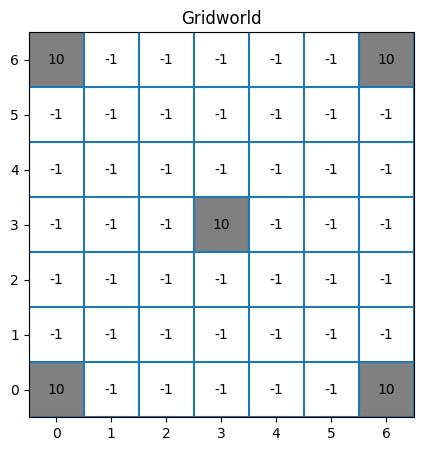

In [ ]:
# Importing the array library
import numpy as np

# Defining the number of blocks of a n x n grid
n = 7

# Defining the value for the hole and the goal
goal = 10
step = -1

# Initiating an empty dataframe of size n x n
R = np.ones((n,n))

# Defining the coordinates of the goal
goal_coords = [(0, n-1), (n-1, 0), (0, 0), (n-1, n-1), (n // 2, n // 2)]

# Adding the goal values to the center and the corners
for goal_coord in goal_coords:
    R[goal_coord[1], goal_coord[0]] = goal

# Every other step is -1
R[R == 1] = step

# Converting the G matrix to int
R = R.astype(int)

# Ploting
plot_matrix(R, goal_coords, title='Gridworld')

In the above example, we have defined our first needed matrix — the R matrix or the reward matrix. The goals are at the centre and at the corners of the grid world. When the agent goes into one of the cells, it receives a reward of the value of that cell.

# Let's define the state matrix

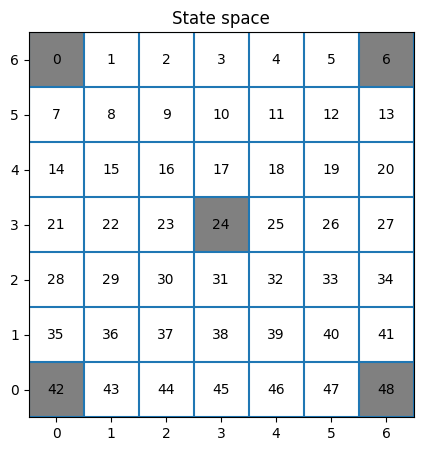

In [ ]:
S = np.arange(0, n*n).reshape(n, n)

plot_matrix(S, goal_coords, title='State space')

In the grid world that we defined, there are in total 49 states that an agent can be in. Each state can be identified by the integer from the matrix.



## Let us assume that our agent is in state 17 and moves down. What's the reward received (action value?

## If the agent is in state 17 and moves to the left, what's the reward received?

## Value function:


## $$ V^\pi (s) = \mathbb{E} \bigg[ \sum_{t\geq 0}^K \gamma^t r_t | s_0 = s, \pi \bigg] $$ where $K$ is the terminal state.

## Policy is $$ \pi (a, s)  = p \in [0, 1]$$ is the probability of taking an action  $a$ in state $s$

Let us initiate the initial value matrix V:



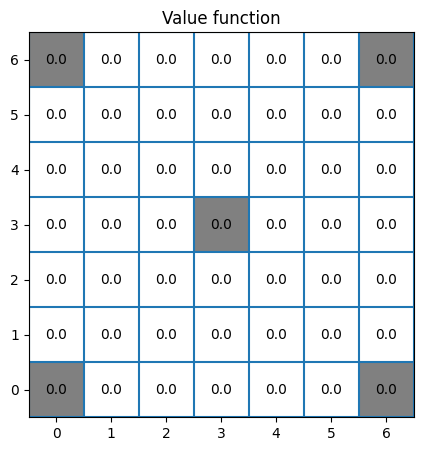

In [ ]:
# Initiating the empty Value function
V = np.zeros((n, n))

plot_matrix(V, goal_coords, title='Value function')

As we have not yet explored our created world of grids, all the returns of the states are 0.

The last matrix we will need is the policy matrix P.

In [ ]:
def plot_policy_matrix(P: dict, S:np.array, goal_coords: list = [], img_width: int = 5, img_height: int = 5, title: str = None) -> None:
    """
    Plots the policy matrix out of the dictionary provided; The dictionary values are used to draw the arrows
    """
    height, width = S.shape

    fig = plt.figure(figsize=(img_width, img_width))
    ax = fig.add_subplot(111, aspect='equal')
    for y in range(height):
        for x in range(width):
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)

            # If there is a tuple of (x, y) in the goal_coords list, we color the cell gray
            if (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))

            else:
                # Adding the arrows to the plot
                if 'up' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, 0, 0.3, head_width = 0.05, head_length = 0.05)
                if 'down' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, 0, -0.3, head_width = 0.05, head_length = 0.05)
                if 'left' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, -0.3, 0, head_width = 0.05, head_length = 0.05)
                if 'right' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, 0.3, 0, head_width = 0.05, head_length = 0.05)


    offset = .5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)

# Saving all the unique states to a vector
states = np.unique(S)

# Dictionary to hold each action for a given state
P = {}
for s in states:
    s_dict = {}

    # Checking which index is the current state in the S matrix
    s_index = np.where(S == s)

    # If the state is in the top left corner, we can only move right and down
    if s_index == (0, 0):
        s_dict['right'] = 0.5
        s_dict['down'] = 0.5

    # If the state is in the top right corner, we can only move left and down
    elif s_index == (0, n - 1):
        s_dict['left'] = 0.5
        s_dict['down'] = 0.5

    # If the state is in the bottom left corner, we can only move right and up
    elif s_index == (n - 1, 0):
        s_dict['right'] = 0.5
        s_dict['up'] = 0.5

    # If the state is in the bottom right corner, we can only move left and up
    elif s_index == (n - 1, n - 1):
        s_dict['left'] = 0.5
        s_dict['up'] = 0.5

    # If the state is in the first row, we can only move left, right, and down
    elif s_index[0] == 0:
        s_dict['left'] = 0.333
        s_dict['right'] = 0.333
        s_dict['down'] = 0.333

    # If the state is in the last row, we can only move left, right, and up
    elif s_index[0] == n - 1:
        s_dict['left'] =  0.333
        s_dict['right'] = 0.333
        s_dict['up'] = 0.333

    # If the state is in the first column, we can only move up, down, and right
    elif s_index[1] == 0:
        s_dict['up'] = 0.333
        s_dict['down'] = 0.333
        s_dict['right'] = 0.333

    # If the state is in the last column, we can only move up, down, and left
    elif s_index[1] == n - 1:
        s_dict['up'] = 0.333
        s_dict['down'] = 0.333
        s_dict['left'] = 0.333

    # If the state is in the middle, we can move in all directions
    else:
        s_dict['up'] = 0.25
        s_dict['down'] = 0.25
        s_dict['left'] = 0.25
        s_dict['right'] = 0.25

    # Saving the current states trasition probabilities
    P[s] = s_dict

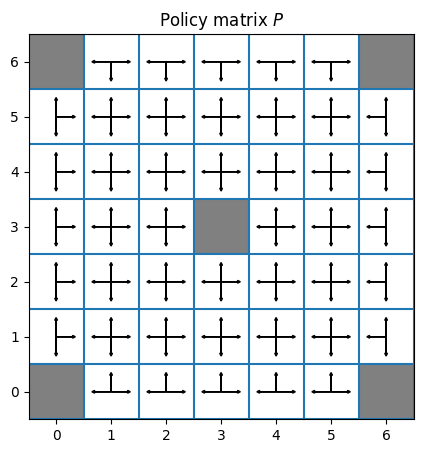

In [ ]:
# Drawing a plot for the policy matrix with arrows; In one cell there can be the maximum of 4 arrows each indicating the action an agent can take
plot_policy_matrix(P, S, goal_coords, title='Policy matrix $P$')

Note tha the above one is not the optimal policy but all possible policy

## Having the R, P, S and V matrices, we can finally start calculating the answer for our RL problem. But we have yet to define, what is the RL objective.

### The objective of an RL algorithm is for the agent to find the optimal policy P that maximizes the returns in each state.



## Having the R, P, S and V matrices, we can finally start calculating the answer for our RL problem. But we have yet to define, what is the RL objective.

## The objective of an RL algorithm is for the agent to find the optimal policy P that maximizes the returns in each state.

## Another formulation is that the objective is to calculate the optimal state values in the matrix V.



## Recall that every value in the V matrix is the total accumulated discounted reward. Thus, our agent would want to always go to the state which has the highest value.

##  We can just list out all the available actions from the current state, check which available state has the highest $V(s)$ value and go there. Looking at the matrices above, we can see that, for example, state 8 has two optimal choices — down and left. This is because these actions will lead the agent into equally good states. Thus having the V matrix, we will always infer the P matrix.

# Value iteration for Grid World problem ca be written as

![image](https://miro.medium.com/v2/resize:fit:640/format:webp/1*Oo1LPPdbyPUjwsc8INrt7g.png)

In [ ]:
def get_next_state(a: str, s: int, S: np.array):
    """
    Function that returns the next state's coordinates given an action and a state
    """
    # Getting the current indexes
    s_index = np.where(S == s)
    s_row = s_index[0][0]
    s_col = s_index[1][0]

    # Defining the indexes of the next state
    next_row = s_row
    next_col = s_col

    if a == 'up':
        next_row = s_row - 1
        next_col = s_col
    elif a == 'down':
        next_row = s_row + 1
        next_col = s_col
    elif a == 'left':
        next_row = s_row
        next_col = s_col - 1
    elif a == 'right':
        next_row = s_row
        next_col = s_col + 1

    return next_row, next_col

In [ ]:
def bellman_value(
    s: int,
    S: np.array,
    P: dict,
    G: np.array,
    V: np.array,
    gamma: float = 0.9
    ) -> Tuple:
    """
    Calculates the Belman equation value for the given state
    """
    # Extracting all the available actions for the given state
    actions = P[s]

    # Placeholder to hold the sum
    sum = 0
    for action in actions:
        # Extracting the probability of the given action
        prob = actions[action]

        # Getting the next states indexes
        next_row, next_col = get_next_state(action, s, S)

        # Extracting the expected reward
        reward = G[next_row, next_col]

        # Extracting the value of the next state
        value_prime = V[next_row, next_col]

        # Adding to the sum
        sum += prob * (reward + gamma * value_prime)

    return sum

In [ ]:
def get_max_return(s: int, S: np.array, P: dict, G: np.array, V: np.array, gamma: float = 0.9) -> Tuple:
    """
    Returns the best action and the Bellman's value for the given state
    """
    # Extracting all the available actions for the given state
    actions = P[s]

    # Placeholder to hold the best action and the max return
    best_action = None
    max_return = -np.inf

    for action in actions:
        # Getting the probability of the action
        prob = actions[action]

        # Getting the next states indexes
        next_row, next_col = get_next_state(action, s, S)

        # Extracting the expected reward
        reward = G[next_row, next_col]

        # Extracting the value of the next state
        value_prime = V[next_row, next_col]

        # Calculating the return
        _return = prob * (reward + gamma * value_prime)

        # Checking if the return is greater than the current max return
        if _return > max_return:
            best_action = action
            max_return = _return

    return best_action, max_return


In [ ]:
def update_value(s, S, P, G, V, gamma) -> float:
    """
    Updates the value function for the given state
    """
    # Getting the indexes of s in S
    s_index = np.where(S == s)
    s_row = s_index[0][0]
    s_col = s_index[1][0]

    # Getting the best action and the Bellman's value
    _, max_return = get_max_return(s, S, P, G, V, gamma)

    # Rounding up the bellman value
    max_return = np.round(max_return, 2)

    # Updating the value function with a rounded value
    V[s_row, s_col] = max_return

    return max_return


In [ ]:
def value_iteration(
    S: np.array,
    P: np.array,
    G: np.array,
    V: np.array,
    gamma: float = 0.9,
    epsilon: float = 0.0001,
    n_iter: int = None
    ) -> None:
    """
    Function that performs the value iteration algorithm

    The function updates the V matrix inplace
    """
    # Iteration tracker
    iteration = 0

    # Iterating until the difference between the value functions is less than epsilon
    iterate = True
    while iterate:
        # Placeholder for the maximum difference between the value functions
        delta = 0

        # Updating the iteration tracker
        iteration += 1
        # Iterating over the states
        for s in S.flatten():
            # Getting the indexes of s in S
            s_index = np.where(S == s)
            s_row = s_index[0][0]
            s_col = s_index[1][0]

            # Saving the current value for the state
            v_init = V[s_row, s_col].copy()

            # Updating the value function
            v_new = update_value(s, S, P, G, V, gamma)

            # Updating the delta
            delta = np.max([delta, np.abs(v_new - v_init)])

            if (delta < epsilon) and (n_iter is None):
                iterate = False
                break

        if (n_iter is not None) and (iteration >= n_iter):
            iterate = False

    # Printing the iteration tracker
    print(f"Converged in {iteration} iterations")

    return None

In [ ]:
def update_policy(S, P, V):
    """
    Function that updates the policy given the value function
    """
    # Iterating over the states
    for s in S.flatten():
        # Listing all the actions
        actions = P[s]

        # For each available action, getting the Bellman's value
        values = {}
        for action in actions.keys():
            # Getting the next state indexes
            next_row, next_col = get_next_state(action, s, S)

            # Saving the value function of that nex t state
            values[action] = V[next_row, next_col]

        # Extracting the maximum key value of the values dictionary
        max_value = max(values.values())

        # Leaving the keys that are equal to the maximum value
        best_actions = [key for key in values if values[key] == max_value]

        # Getting the length of the dictionary
        length = len(values)

        # Creating the final dictionary with all the best actions in it
        p_star = {}
        for action in best_actions:
            p_star[action] = 1/length

        # Updating the policy
        P[s] = p_star

## Now let us update one state - the first or $s = 1$.



In [ ]:
update_value(1, S, P, R, V, gamma=0.9)
update_policy(S, P, V)

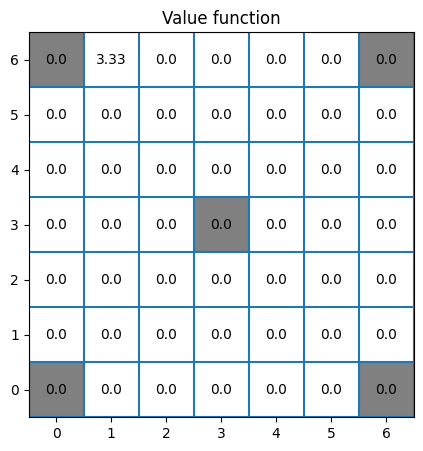

In [ ]:
plot_matrix(V, goal_coords, title='Value function')

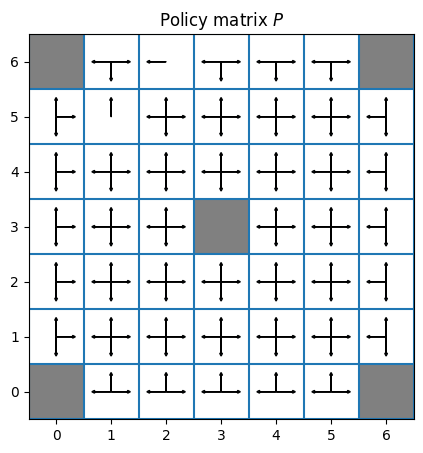

In [ ]:
plot_policy_matrix(P, S, goal_coords, title='Policy matrix $P$')

## Let us now update state 3 and see what is happening:



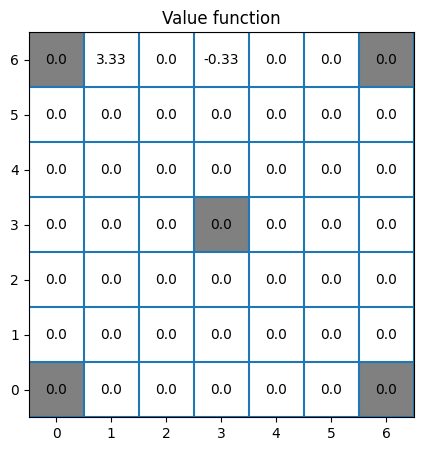

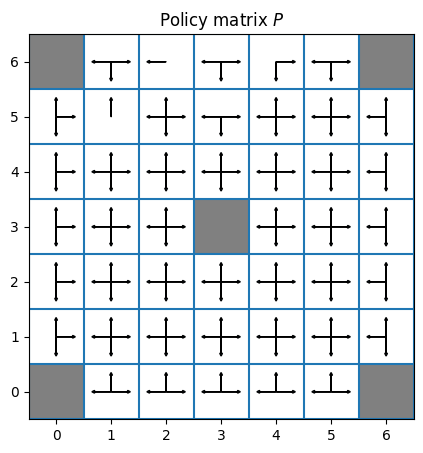

In [ ]:
update_value(3, S, P, R, V, gamma=0.9)
update_policy(S, P, V)
plot_matrix(V, goal_coords, title='Value function')
plot_policy_matrix(P, S, goal_coords, title='Policy matrix $P$')


## The value iteration algorithm works in the exact same fashion as above just for all the states (in our case — from states 0 to 48). To implement it use the following code:

In [ ]:
value_iteration(S, P, R, V, epsilon=10**-16)
update_policy(S, P, V)

Converged in 6 iterations


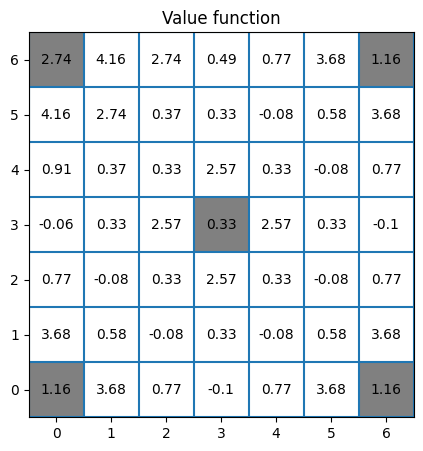

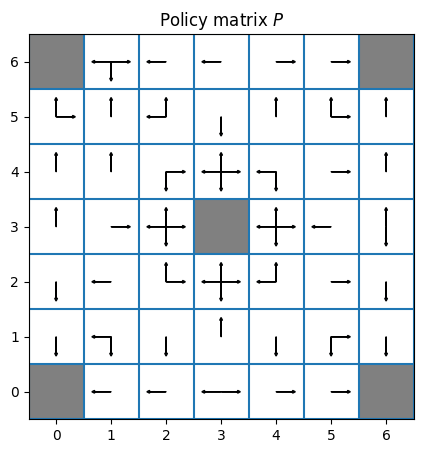

In [ ]:
plot_matrix(V, goal_coords, title='Value function')
plot_policy_matrix(P, S, goal_coords, title='Policy matrix $P$')

## The agent could start in any non-terminal state and move along the arrows in the policy matrix. If there are two or more arrows in the same state, we can move with the same probability into each of the states that the arrows are pointing to.